In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.keras._impl.keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [83]:
dataset = pd.read_csv('./cdn_memory_used.csv', usecols=[0,1,2], index_col=[0], parse_dates=[0])


In [84]:
dataset['2019-01-25 16:01:17']

,host,value
time,,
2019-01-25 16:01:17,fj3-cmcdn0.fjnd.cmcdn.net,5.31417


In [85]:
dataset = dataset.drop(dataset[dataset['host']=='fj3-cmcdn0.fjnd.cmcdn.net'].index, axis=0)
dataset = dataset.drop(dataset[dataset['host']=='gxdd2-cmcdn1.gxnn.cmcdn.net'].index, axis=0)


In [86]:
datasets = []
datasets.append(dataset[dataset['host']=='jswx01-cmcdn0.jswx.cmcdn.net'])
datasets.append(dataset[dataset['host']=='jswx04-cmcdn0.jswx.cmcdn.net'])
datasets.append(dataset[dataset['host']=='sc3-cmcdn3.scyd.cmcdn.net'])
datasets.append(dataset[dataset['host']=='zjwz-cmcdn8.wzyd.cmcdn.net'])
datasets.append(dataset[dataset['host']=='zjwz-cmcdn9.wzyd.cmcdn.net'])

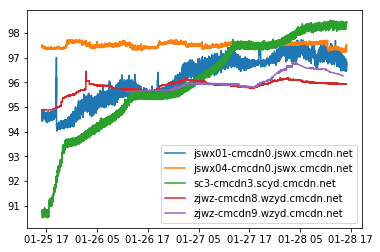

In [87]:
title = ['jswx01-cmcdn0.jswx.cmcdn.net', 'jswx04-cmcdn0.jswx.cmcdn.net', 'sc3-cmcdn3.scyd.cmcdn.net',
        'zjwz-cmcdn8.wzyd.cmcdn.net', 'zjwz-cmcdn9.wzyd.cmcdn.net']
for i in range(len(datasets)):
    plt.plot(datasets[i].value, label=title[i])
    plt.legend()
plt.show()

In [88]:
training_set = datasets[0].iloc[:, 1:2].values
training_set

array([[94.69783302],
       [94.42522675],
       [94.46262695],
       ...,
       [96.71681668],
       [96.844235  ],
       [96.71085205]])

In [89]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [90]:
# steps = 180
# X_train = []
# Y_train = []
# for i in range(steps, len(training_set_scaled)):
#     X_train.append(training_set_scaled[i-steps])
#     Y_train.append(training_set_scaled[i, 0])
# X_train, Y_train = np.array(X_train), np.array(Y_train)

In [91]:
def create_train_dataset(dataset, steps):
    X_train, Y_train = [], []
    for i in range(steps, len(dataset)):
        X_train.append(training_set_scaled[i-steps])
        Y_train.append(training_set_scaled[i, 0])
    return np.array(X_train), np.array(Y_train)

In [92]:
split_rate = 0.7
k = int(len(training_set_scaled)*split_rate)
def create_test_dataset(dataset, steps):
    X_test, Y_test = [], []
    for i in range(steps, len(dataset)):
        X_test.append(training_set_scaled[i-steps+k])
        Y_test.append(training_set_scaled[i+k, 0])
    return np.array(X_test), np.array(Y_test)


In [93]:
train_size = int(len(training_set) * split_rate)
test_size = len(training_set) - train_size
train, test = training_set[0:train_size], training_set[train_size:len(training_set)]


In [94]:
train.shape,train, test.shape, training_set.shape

((18139, 1), array([[94.69783302],
        [94.42522675],
        [94.46262695],
        ...,
        [96.78097895],
        [96.79936384],
        [96.78685569]]), (7775, 1), (25914, 1))

In [95]:
steps = 180
X_train, Y_train = create_train_dataset(train, steps)
X_test, Y_test = create_test_dataset(test, steps)

In [96]:
Y_train.shape,Y_train, X_train.shape,X_train, X_test.shape

((17959,),
 array([0.2065412 , 0.18270075, 0.17291538, ..., 0.73208432, 0.73695732,
        0.73364197]),
 (17959, 1),
 array([[0.17993649],
        [0.10768089],
        [0.11759399],
        ...,
        [0.73545349],
        [0.74174999],
        [0.73637812]]),
 (7595, 1))

In [97]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [76]:
X_train.shape

(17959, 1, 1)

In [77]:
regressor = tf.keras.models.Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='adam')

regressor.fit(X_train, Y_train, epochs=3, batch_size = 10)


Epoch 1/3
17959/17959 [==============================] - 17s 966us/step - loss: 0.0109
Epoch 2/3
17959/17959 [==============================] - 11s 611us/step - loss: 0.0041
Epoch 3/3
17959/17959 [==============================] - 11s 610us/step - loss: 0.0036


In [111]:
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)
trainPredict.shape, testPredict.shape

((17959, 1), (7595, 1))

In [79]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_test])
trainY,testY

(array([[94.79820741, 94.70826204, 94.67134373, ..., 96.78097895,
         96.79936384, 96.78685569]]),
 array([[96.81849432, 96.79456607, 96.79743322, ..., 96.71681668,
         96.844235  , 96.71085205]]))

In [80]:
trainPredict, trainY, testPredict, testY

(array([[94.75178 ],
        [94.54271 ],
        [94.569695],
        ...,
        [96.77953 ],
        [96.79145 ],
        [96.78133 ]], dtype=float32),
 array([[94.79820741, 94.70826204, 94.67134373, ..., 96.78097895,
         96.79936384, 96.78685569]]),
 array([[96.77309 ],
        [96.785965],
        [96.78125 ],
        ...,
        [96.7273  ],
        [96.715904],
        [96.79319 ]], dtype=float32),
 array([[96.81849432, 96.79456607, 96.79743322, ..., 96.71681668,
         96.844235  , 96.71085205]]))

In [81]:
import math
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.19 RMSE
Test Score: 0.34 RMSE


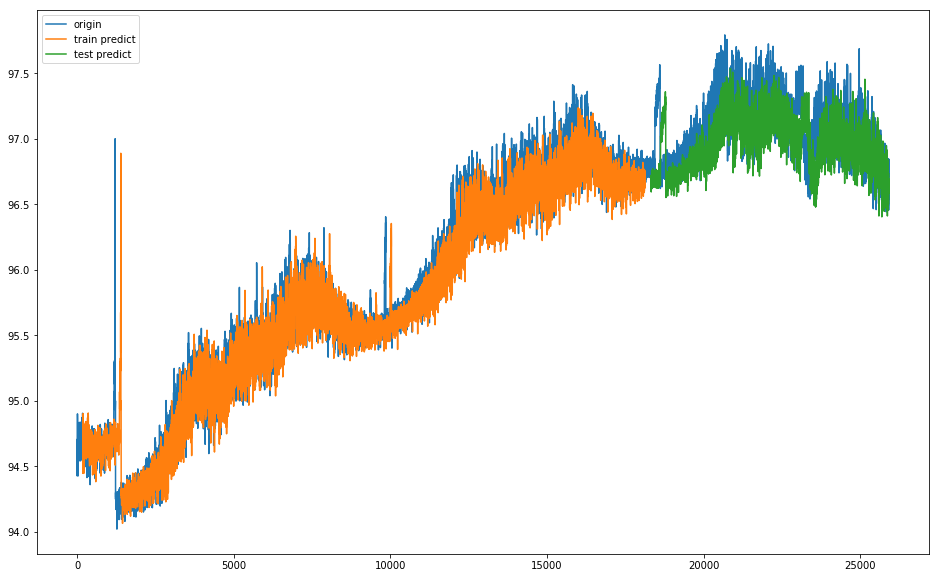

In [23]:
trainPredictPlot = np.empty_like(training_set)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[steps:len(trainPredict)+steps, :] = trainPredict

testPredictPlot = np.empty_like(training_set)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(steps*2):len(training_set),:] = testPredict

plt.figure(figsize=(16,10))
plt.plot(training_set, label = 'origin')
plt.plot(trainPredictPlot, label = 'train predict')
plt.plot(testPredictPlot, label = 'test predict')

plt.legend()
plt.show()


In [112]:
def model_build():
    regressor = tf.keras.models.Sequential()
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(tf.keras.layers.Dropout(0.2))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(tf.keras.layers.Dropout(0.2))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(tf.keras.layers.Dropout(0.2))

    regressor.add(LSTM(units=50))
    regressor.add(tf.keras.layers.Dropout(0.2))

    regressor.add(tf.keras.layers.Dense(units=1))

    regressor.compile(loss='mean_squared_error', optimizer='adam')
    return regressor
    

In [ ]:
model_grid_search = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=model_build,verbose=1)
batch_size = [1,10]
epochs = [1,3]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model_grid_search, param_grid=param_grid,n_jobs=1)
grid_result = grid.fit(X_train, Y_train)
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
